# Performing pyscenic on atlas to idenitify regulons

#### problems with pyscenic package and dependencies, therefore for all bash commands in this notebook, instead of running in my normal environment (env) run in environment called pyscenic2 (mamba activate pyscenic2) as this environmemnt has the correct package versions needed

* pyscenic installed on environemnt: https://pyscenic.readthedocs.io/en/latest/installation.html#docker-podman-and-singularity-apptainer-images 
* pyscenic pipline based on: https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.html
* GRN inference run using arboreto method: https://pyscenic.readthedocs.io/en/latest/faq.html#i-am-having-problems-with-dask

# Making environment for running bash commands


``` bash 
conda create -y -n pyscenic2 python=3.10
conda activate pyscenic2

# Install pySCENIC locally
mkdir /scratch/user/s4436039/software/
cd /scratch/user/s4436039/software/
git clone https://github.com/aertslab/pySCENIC.git
cd pySCENIC/
pip install -e . # this will install pySCENIC in editable mode

# Fix the dependencies
# also install loompy from the github becaues they fixed the issue with normalize.py 
# https://github.com/linnarsson-lab/loompy/issues/186
pip install git+https://www.github.com/linnarsson-lab/loompy.git
# use numpy==1.24.0 because of https://github.com/aertslab/pySCENIC/issues/584
pip install numpy==1.24.0

cd /scratch/user/s4436039/scdata/PySCENIC

#running pyscenic (step that was giving error in normal environment)
pyscenic aucell \
    DC1mreg_loom.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 1
```

# Load packages

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# Import h5ad

In [2]:
#set current directory 
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

In [3]:
# read in data
data = sc.read_h5ad('NRclean_clustered2.h5ad')

In [4]:
#subset out DCs
data_DC = data[data.obs["NR_annotations_simple"].isin(["cDC1","cDC2","mregDC"])]

In [7]:
data_DC

View of AnnData object with n_obs × n_vars = 30241 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_a

In [21]:
os.chdir('/scratch/user/s4436039/scdata/PySCENIC_Jan')
os.getcwd()

'/scratch/user/s4436039/scdata/PySCENIC_Jan'

## make loom file with expression data:

In [4]:
import loompy as lp
import numpy as np

In [10]:
# Save the path where you want loom file to save (current directory)
f_loom_path_DC = "DC_loom.loom"

In [11]:
row_attrs = { 
    "Gene": np.array(data_DC.var.index) ,
}
col_attrs = { 
    "CellID":  np.array(data_DC.obs.index) ,
    "nGene": np.array( np.sum(data_DC.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(data_DC.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_DC, data_DC.X.transpose(), row_attrs, col_attrs )

## 1. GRN Inference - Run GRN pyscenic 
* TF list (allTFs_hg38.txt) downloaded from https://resources.aertslab.org/cistarget/tf_lists/ 

### Run in bash (in pyscenic2 environment): 

``` bash
cd /scratch/user/s4436039/scdata/PySCENIC_Jan
arboreto_with_multiprocessing.py DC_loom.loom allTFs_hg38.txt --output adj.tsv --num_workers 20
```
* can use 20 workers as i requested bunya job with 20 cpus (~5min)

In [12]:
# read in the adjacencies matrix
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

In [13]:
adjacencies.head()

,TF,target,importance
0,PSMA6,GABARAP,28.059309
1,IRF8,CLEC9A,27.532223
2,IRF8,CLNK,24.721919
3,IRF8,RGCC,22.454228
4,NR4A1,DUSP2,20.902900


# 2. Cis-Regulatory Analysis - Regulon prediction 
* output: the regulons in reg.csv - list of adjacencies between a TF and its targets stored in MOTIFS_FNAME
* ranking database downloaded from: https://resources.aertslab.org/cistarget/databases/ details --> used Homo sapiens - hg38 - refseq_r80 - SCENIC+ databases - Gene based - hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather
* motif-to-TF database downloaded from: https://resources.aertslab.org/cistarget/motif2tf/ (this database links TF binding motifs to their corresponding TFs)

### ctx step: cis-regulatory motif analysis 

### Run in bash (in pyscenic2 environment):

``` bash
pyscenic ctx adj.tsv \
    hg38_10kbp_up_10kbp_down_full_tx_v10_clust.genes_vs_motifs.rankings.feather \
    --annotations_fname motifs-v10nr_clust-nr.hgnc-m0.001-o0.0.tbl \
    --expression_mtx_fname DC_loom.loom \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20
```

# Regulon Activity/Cellular enrichment (aucell)
* identifies the activity of these regulons at the single cell level by calculating an enrichment score

### First checking most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC (as done in tutorial)

In [14]:
nGenesDetectedPerCellbefore = np.sum(data_DC.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCellbefore)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

0.01     27.0
0.05     47.0
0.10     70.0
0.50    171.0
1.00    503.0
dtype: float64


In [15]:
import seaborn as sns

/scratch/temp/12142480/ipykernel_2362699/3887338572.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')


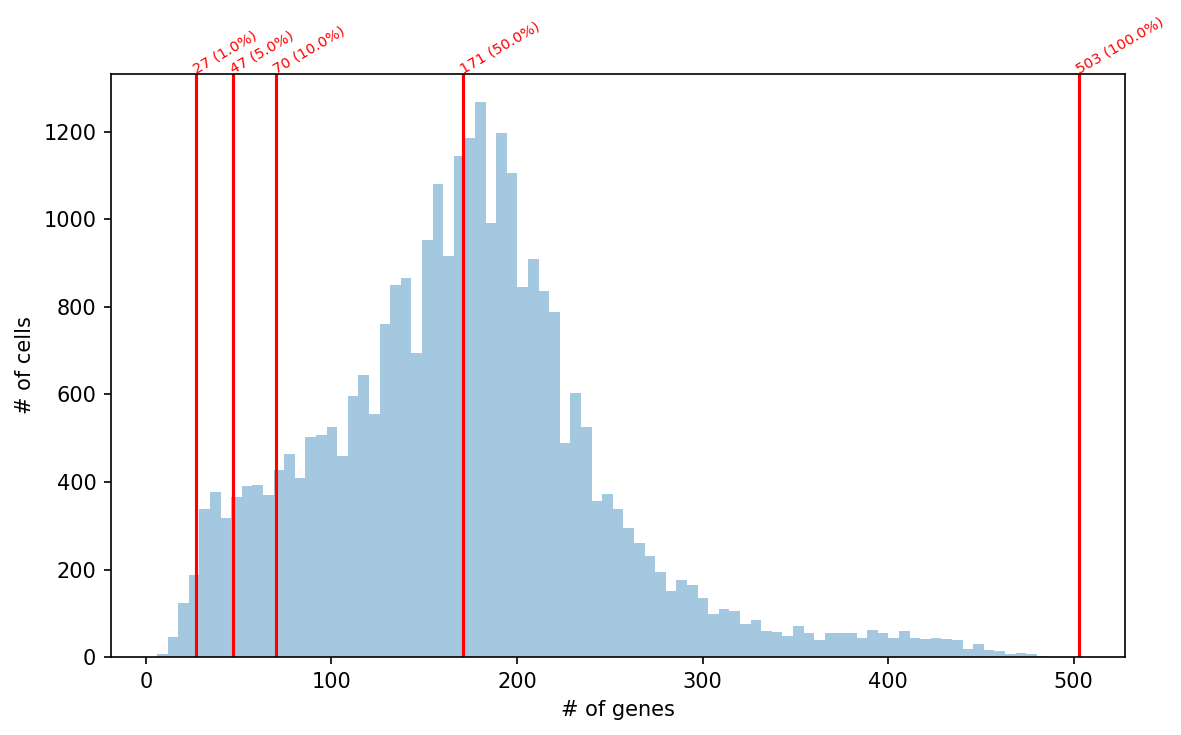

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small', rotation_mode='anchor')
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

* default auc_threshold is 0.05 (5%) which here would include 47 genes 

## Run AUC (area under the curve for enrichment algorithm to calculate regulon activity scores):

### Run in bash (in pyscenic2 environment):

``` bash
pyscenic aucell \
    DC_loom.loom \
    reg.csv \
    --output pyscenic_output.loom \
    --num_workers 20

## Output SCENIC's AUC matrix:

In [5]:
import json
import zlib
import base64

In [8]:
# collect SCENIC AUCell output
lf = lp.connect("pyscenic_output.loom", mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [9]:
# activity score for each regulon (column) for every cell (row)
auc_mtx.head()

,AHR(+),ATF3(+),BACH2(+),BATF(+),BHLHE40(+),BHLHE41(+),CREM(+),DDIT3(+),ELF3(+),ETS1(+),...,MAF(+),MAFF(+),NFE2(+),NFKB1(+),NFKB2(+),NR1H3(+),PRDM1(+),REL(+),SOX4(+),TCF7L2(+)
GSE215120_AM1_AAATGCCCAGAGCCAA-1,0.014815,0.032522,0.017493,0.008354,0.033690,0.084034,0.030231,0.121693,0.031746,0.022378,...,0.022011,0.046005,0.000000,0.021613,0.053894,0.062434,0.000000,0.031684,0.004141,0.011905
GSE215120_AM1_ACACTGATCCACTGGG-1,0.001411,0.038906,0.011986,0.044277,0.062196,0.000000,0.041956,0.000000,0.000000,0.041634,...,0.012275,0.052569,0.000000,0.029549,0.078627,0.004233,0.017094,0.041892,0.025190,0.000000
GSE215120_AM1_ACAGCCGCAAACCTAC-1,0.043563,0.041494,0.022190,0.000000,0.046647,0.000000,0.047858,0.243386,0.052910,0.006245,...,0.026878,0.028302,0.009009,0.026998,0.021041,0.005291,0.000000,0.028260,0.049517,0.000000
GSE215120_AM1_ACCAGTAAGACTGGGT-1,0.039330,0.021653,0.034338,0.000000,0.047295,0.056956,0.026721,0.000000,0.000000,0.004424,...,0.014392,0.032015,0.016731,0.026006,0.015873,0.023280,0.000000,0.028820,0.056418,0.000000
GSE215120_AM1_ACGTCAACAAGGACTG-1,0.003880,0.004227,0.000000,0.000000,0.025267,0.000000,0.010848,0.161376,0.137566,0.020557,...,0.008254,0.015496,0.000000,0.019629,0.001107,0.000000,0.000000,0.019048,0.043306,0.000000


In [10]:
#export matrix as csv
auc_mtx.to_csv("auc_matrix.csv", index=True)  # Set index=False to exclude the index column

In [22]:
# read in csv
auc = pd.read_csv('auc_matrix.csv', index_col=0)

In [23]:
auc.head()

,AHR(+),ATF3(+),BACH2(+),BATF(+),BHLHE40(+),BHLHE41(+),CREM(+),DDIT3(+),ELF3(+),ETS1(+),...,MAF(+),MAFF(+),NFE2(+),NFKB1(+),NFKB2(+),NR1H3(+),PRDM1(+),REL(+),SOX4(+),TCF7L2(+)
GSE215120_AM1_AAATGCCCAGAGCCAA-1,0.014815,0.032522,0.017493,0.008354,0.033690,0.084034,0.030231,0.121693,0.031746,0.022378,...,0.022011,0.046005,0.000000,0.021613,0.053894,0.062434,0.000000,0.031684,0.004141,0.011905
GSE215120_AM1_ACACTGATCCACTGGG-1,0.001411,0.038906,0.011986,0.044277,0.062196,0.000000,0.041956,0.000000,0.000000,0.041634,...,0.012275,0.052569,0.000000,0.029549,0.078627,0.004233,0.017094,0.041892,0.025190,0.000000
GSE215120_AM1_ACAGCCGCAAACCTAC-1,0.043563,0.041494,0.022190,0.000000,0.046647,0.000000,0.047858,0.243386,0.052910,0.006245,...,0.026878,0.028302,0.009009,0.026998,0.021041,0.005291,0.000000,0.028260,0.049517,0.000000
GSE215120_AM1_ACCAGTAAGACTGGGT-1,0.039330,0.021653,0.034338,0.000000,0.047295,0.056956,0.026721,0.000000,0.000000,0.004424,...,0.014392,0.032015,0.016731,0.026006,0.015873,0.023280,0.000000,0.028820,0.056418,0.000000
GSE215120_AM1_ACGTCAACAAGGACTG-1,0.003880,0.004227,0.000000,0.000000,0.025267,0.000000,0.010848,0.161376,0.137566,0.020557,...,0.008254,0.015496,0.000000,0.019629,0.001107,0.000000,0.000000,0.019048,0.043306,0.000000


# Transfer regulon scores back to full atlas

In [47]:
#show current directory 
os.getcwd()
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

In [48]:
data_clean = sc.read_h5ad('/scratch/user/s4436039/scdata/Python_Integration_Sep/NRclean_clustered2.h5ad')

In [15]:
data_clean.obs

,nCount_RNA,nFeature_RNA,sample_type,cancer_type,patient_id,sample_id,percent.mt,site,sample_type_major,cancer_subtype,...,DC3_up_DC2,mregDC_sig,cDC1_mregDC,cDC2_mregDC,NR_annotations,NR_annotations_simple,sample_type_major2,cancer_with_H,cancer_broadest,CytoTRACE_DC_Predicted_order
GSE215120_AM1_AAACCTGGTTGCTCCT-1,20298.000000,3789.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,0.975466,skin,primary tumour,Acral Melanoma,...,0.082309,0.435951,0.279165,0.553687,Tissue resident macrophage,Tissue resident macrophage,primary tumour,Acral Melanoma,MEL,NaN
GSE215120_AM1_AAAGATGTCCAAATGC-1,5574.000000,1721.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,6.045928,skin,primary tumour,Acral Melanoma,...,0.189334,0.275931,0.177009,0.444586,Tissue resident macrophage,Tissue resident macrophage,primary tumour,Acral Melanoma,MEL,NaN
GSE215120_AM1_AAATGCCCAGAGCCAA-1,17143.000000,2659.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,1.224990,skin,primary tumour,Acral Melanoma,...,0.124530,0.427229,0.259460,0.489422,cDC2,cDC2,primary tumour,Acral Melanoma,MEL,0.354550
GSE215120_AM1_ACACTGAAGATCCCGC-1,5912.000000,1374.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,2.503383,skin,primary tumour,Acral Melanoma,...,0.470527,0.223862,0.230512,0.458001,Classical monocytes,Classical monocytes,primary tumour,Acral Melanoma,MEL,NaN
GSE215120_AM1_ACACTGATCCACTGGG-1,18333.000000,2845.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,1.063656,skin,primary tumour,Acral Melanoma,...,0.226950,0.617883,0.281696,0.620768,cDC2,cDC2,primary tumour,Acral Melanoma,MEL,0.370462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTCATGGTTACCTGA,-4.499666,-9.853381,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1779.000000,ovary,primary tumour,HGSOC,...,0.352543,-0.008449,0.186892,0.480665,Classical monocytes,Classical monocytes,primary tumour,HGSOC,HGSOC,NaN
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTCGATGTGACGTCC,-4.871771,-10.337130,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1541.000000,ovary,primary tumour,HGSOC,...,0.371402,-0.061037,0.183097,0.464420,Classical monocytes,Classical monocytes,primary tumour,HGSOC,HGSOC,NaN
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTCGATTCTGCGAGC,-4.766977,-8.292435,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,2596.000000,ovary,primary tumour,HGSOC,...,0.193778,0.497721,0.163307,0.524392,Tissue resident macrophage,Tissue resident macrophage,primary tumour,HGSOC,HGSOC,NaN
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTGATCGTTGCTCCT,-4.133310,-8.758132,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1200.000000,ovary,primary tumour,HGSOC,...,0.127235,0.068393,0.141191,0.438729,Tissue resident macrophage,Tissue resident macrophage,primary tumour,HGSOC,HGSOC,NaN


In [25]:
# Reindex auc to match the cells in data_clean.obs.index, filling missing values with NaN
auc_reindexed = auc.reindex(data_clean.obs.index)

In [26]:
auc_reindexed.head()

,AHR(+),ATF3(+),BACH2(+),BATF(+),BHLHE40(+),BHLHE41(+),CREM(+),DDIT3(+),ELF3(+),ETS1(+),...,MAF(+),MAFF(+),NFE2(+),NFKB1(+),NFKB2(+),NR1H3(+),PRDM1(+),REL(+),SOX4(+),TCF7L2(+)
GSE215120_AM1_AAACCTGGTTGCTCCT-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE215120_AM1_AAAGATGTCCAAATGC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE215120_AM1_AAATGCCCAGAGCCAA-1,0.014815,0.032522,0.017493,0.008354,0.033690,0.084034,0.030231,0.121693,0.031746,0.022378,...,0.022011,0.046005,0.0,0.021613,0.053894,0.062434,0.000000,0.031684,0.004141,0.011905
GSE215120_AM1_ACACTGAAGATCCCGC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE215120_AM1_ACACTGATCCACTGGG-1,0.001411,0.038906,0.011986,0.044277,0.062196,0.000000,0.041956,0.000000,0.000000,0.041634,...,0.012275,0.052569,0.0,0.029549,0.078627,0.004233,0.017094,0.041892,0.025190,0.000000


In [27]:
# Add each column from auc_reindexed as metadata in data_clean
for column in auc_reindexed.columns:
    data_clean.obs[column] = auc_reindexed[column]

In [28]:
data_clean.obs

,nCount_RNA,nFeature_RNA,sample_type,cancer_type,patient_id,sample_id,percent.mt,site,sample_type_major,cancer_subtype,...,MAF(+),MAFF(+),NFE2(+),NFKB1(+),NFKB2(+),NR1H3(+),PRDM1(+),REL(+),SOX4(+),TCF7L2(+)
GSE215120_AM1_AAACCTGGTTGCTCCT-1,20298.000000,3789.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,0.975466,skin,primary tumour,Acral Melanoma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE215120_AM1_AAAGATGTCCAAATGC-1,5574.000000,1721.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,6.045928,skin,primary tumour,Acral Melanoma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE215120_AM1_AAATGCCCAGAGCCAA-1,17143.000000,2659.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,1.224990,skin,primary tumour,Acral Melanoma,...,0.022011,0.046005,0.0,0.021613,0.053894,0.062434,0.000000,0.031684,0.004141,0.011905
GSE215120_AM1_ACACTGAAGATCCCGC-1,5912.000000,1374.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,2.503383,skin,primary tumour,Acral Melanoma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE215120_AM1_ACACTGATCCACTGGG-1,18333.000000,2845.000000,tumour,Acral Melanoma,AM1,GSE215120_Acral_MEL_AM1,1.063656,skin,primary tumour,Acral Melanoma,...,0.012275,0.052569,0.0,0.029549,0.078627,0.004233,0.017094,0.041892,0.025190,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTCATGGTTACCTGA,-4.499666,-9.853381,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1779.000000,ovary,primary tumour,HGSOC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTCGATGTGACGTCC,-4.871771,-10.337130,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1541.000000,ovary,primary tumour,HGSOC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTCGATTCTGCGAGC,-4.766977,-8.292435,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,2596.000000,ovary,primary tumour,HGSOC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSE180661_HGSOC_SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY_TTTGATCGTTGCTCCT,-4.133310,-8.758132,Adnexa,HGSOC,Left Adnexa,SPECTRUM-OV-045_S1_CD45P_LEFT_OVARY,1200.000000,ovary,primary tumour,HGSOC,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
data_clean

AnnData object with n_obs × n_vars = 498023 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotati

In [30]:
#update object 
data_clean.write_h5ad("NRclean_clustered2.h5ad", compression="gzip")

# Plot regulon specificity score 
* see Fig 3B,D from this paper as an example: https://insight.jci.org/articles/view/159751/sd/1
* https://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/SCENIC%20Protocol%20-%20Case%20study%20-%20Cancer%20data%20sets.html

### Run in terminal (start python session):
* regulon_specificity_scores wouldn't run correctly in jpynb due to depedency issues, instead start a python session in terminal in pyscenic2 environment (had to download scanpy package to pyscenic2 first)

``` python
import scanpy as sc
data_clean = sc.read_h5ad('/scratch/user/s4436039/scdata/Python_Integration_Sep/NRclean_clustered2.h5ad')
import pandas as pd
import os
os.chdir('/scratch/user/s4436039/scdata/PySCENIC_Jan')
auc = pd.read_csv('auc_matrix.csv', index_col=0)
data_DC = data_clean[data_clean.obs["NR_annotations_simple"].isin(["cDC1","cDC2","mregDC"])]
from pyscenic.rss import regulon_specificity_scores
rss = regulon_specificity_scores(auc, data_DC.obs["NR_annotations_simple"])
rss.head()
rss.to_csv("rss_matrix.csv", index=True)

### Plot in notebook:

In [2]:
os.chdir('/scratch/user/s4436039/scdata/PySCENIC_Jan')
os.getcwd()

'/scratch/user/s4436039/scdata/PySCENIC_Jan'

In [3]:
#read in csv
rss = pd.read_csv('rss_matrix.csv', index_col=0)

In [4]:
rss.head()

,AHR(+),ATF3(+),BACH2(+),BATF(+),BHLHE40(+),BHLHE41(+),CREM(+),DDIT3(+),ELF3(+),ETS1(+),...,MAF(+),MAFF(+),NFE2(+),NFKB1(+),NFKB2(+),NR1H3(+),PRDM1(+),REL(+),SOX4(+),TCF7L2(+)
cDC2,0.623930,0.574565,0.576337,0.308582,0.597653,0.401268,0.640057,0.302762,0.231817,0.434742,...,0.505293,0.557729,0.619684,0.553317,0.403644,0.317570,0.428394,0.553135,0.433312,0.398315
cDC1,0.340287,0.281992,0.335557,0.226112,0.280120,0.342571,0.302136,0.270837,0.214173,0.271364,...,0.304757,0.291424,0.328547,0.312019,0.254158,0.208155,0.204543,0.301248,0.327925,0.274653
mregDC,0.254949,0.360270,0.302580,0.497871,0.334520,0.231676,0.291203,0.226210,0.235571,0.493126,...,0.272608,0.404839,0.208943,0.392974,0.539655,0.249754,0.243073,0.413057,0.490423,0.273837


In [5]:
import seaborn as sns

#### Define plot_rss function:
* can also import directly with ```from pyscenic.plotting import plot_rss``` but then can't edit 
* fundtion from here: https://github.com/aertslab/pySCENIC/blob/master/src/pyscenic/plotting.py

#### Original Function: 

``` python
from math import ceil, floor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_rss(rss, cell_type, top_n=5, max_n=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    if max_n is None:
        max_n = rss.shape[1]
    data = rss.T[cell_type].sort_values(ascending=False)[0:max_n]
    ax.plot(np.arange(len(data)), data, ".")
    ax.set_ylim([floor(data.min() * 100.0) / 100.0, ceil(data.max() * 100.0) / 100.0])
    ax.set_ylabel("RSS")
    ax.set_xlabel("Regulon")
    ax.set_title(cell_type)
    ax.set_xticklabels([])

    font = {
        "color": "red",
        "weight": "normal",
        "size": 4,
    }

    for idx, (regulon_name, rss_val) in enumerate(
        zip(data[0:top_n].index, data[0:top_n].values)
    ):
        ax.plot([idx, idx], [rss_val, rss_val], "r.")
        ax.text(
            idx + (max_n / 25),
            rss_val,
            regulon_name,
            fontdict=font,
            horizontalalignment="left",
            verticalalignment="center",
        )

#### My version: 

In [42]:
from math import ceil, floor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_rss(rss, cell_type, top_n=5, max_n=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(4, 4))
    if max_n is None:
        max_n = rss.shape[1]
    data = rss.T[cell_type].sort_values(ascending=False)[0:max_n]
    ax.plot(np.arange(len(data)), data, ".")
    ax.set_ylim([floor(data.min() * 100.0) / 100.0, ceil(data.max() * 100.0) / 100.0])
    ax.set_ylabel("RSS")
    ax.set_xlabel("Regulon")
    ax.set_title(cell_type)
    ax.set_xticklabels([])

    font = {
        "color": "red",
        "weight": "normal",
        "size": 8,
    }

    for idx, (regulon_name, rss_val) in enumerate(
        zip(data[0:top_n].index, data[0:top_n].values)
    ):
        ax.plot([idx, idx], [rss_val, rss_val], "r.")
        ax.text(
            idx + (max_n / 25),
            rss_val,
            regulon_name,
            fontdict=font,
            horizontalalignment="left",
            verticalalignment="center",
        )

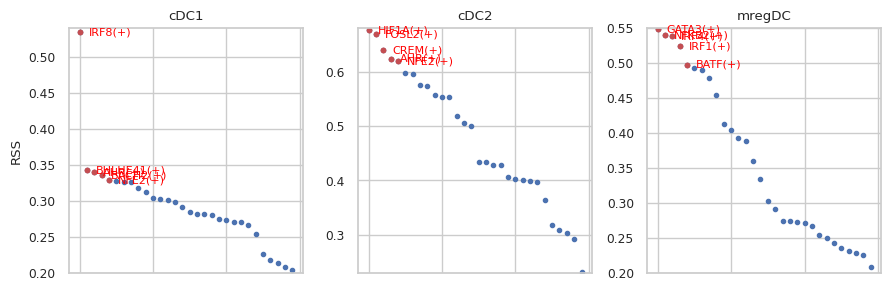

In [43]:
sns.set()
sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(9, 3), dpi=100)

plot_rss(rss, 'cDC1', ax=ax1)
ax1.set_xlabel('')

plot_rss(rss, 'cDC2', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')

plot_rss(rss, 'mregDC', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')

plt.tight_layout()

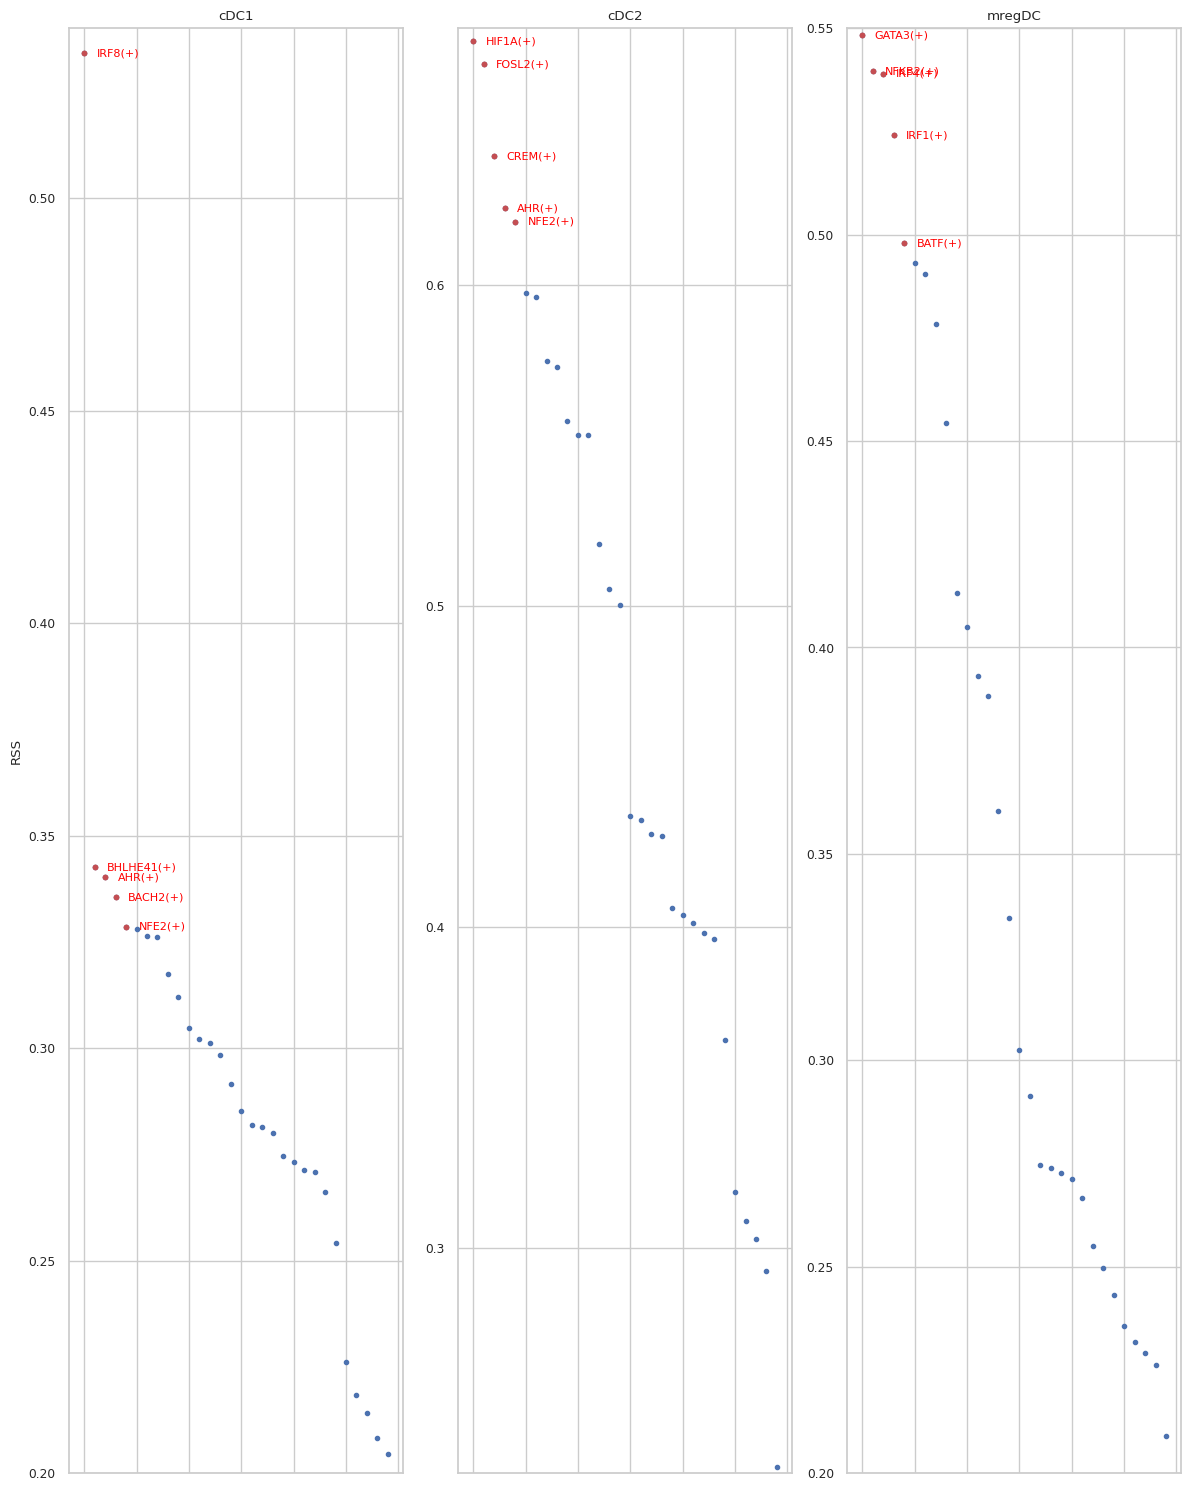

In [46]:
sns.set()
sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 15), dpi=100)

plot_rss(rss, 'cDC1', ax=ax1)
ax1.set_xlabel('')

plot_rss(rss, 'cDC2', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')

plot_rss(rss, 'mregDC', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')

plt.tight_layout()